In [1]:
import json
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
files = {'debt': 'data/Campaign_Finance_Disclosure_Debt_Data_Current_State.csv',
         'receipt':'data/Campaign_Finance_Disclosure_Receipt_Data_Current_State.csv',
         'filer': 'data/Campaign_Finance_Disclosure_Filer_Data_Current_State.csv',
         'expense': 'data/Campaign_Finance_Disclosure_Expense_Data_Current_State.csv',
         'contributions': 'data/Campaign_Finance_Disclosure_Contributions_Data_2017_State.csv',
         'lobbyists': 'data/Lobbying_Disclosure_Data_2017_State.csv'}

# Utilities

In [3]:
def amount_to_float(amount):
    if type(amount) == float and np.isnan(amount):
        return np.nan
    pattern = re.compile(r'\$(.*)')
    g = re.match(pattern, amount)
    if g:
        return float(g.groups()[0])
    else:
        return np.nan

In [4]:
def extract_lat_long(x):
    pattern = re.compile(r'\((.*), (.*)\)')
    lat, long = np.nan, np.nan
    if type(x) == float and np.isnan(x):
        return lat, long
    for y in x.split('\n'):
        g = re.match(pattern, y)
        if g:
            lat, long = g.groups()
    return float(lat), float(long)


def get_lat_long(x, string=None):
    lat, long = extract_lat_long(x[string + ' Location 1'])
    if np.isnan(lat):
        lat, long = extract_lat_long(x[string + ' Location 2'])
    return '{} {}'.format(lat, long)


def get_df_lat_long(df, string):
    new_pd = df.apply(get_lat_long, axis=1, string=string).str.split(expand=True).astype(float)
    df[['lat', 'long']] = new_pd.copy()
    return df

# Debt

In [5]:
debt = pd.read_csv(files['debt'])
debt.fillna('', inplace=True)
debt['Debt Accrual Date'] = pd.to_datetime(debt['Debt Accrual Date'].astype(str),
                                           format='%Y%m%d.0',
                                           errors='coerce')

In [6]:
debt['amount'] = debt['Debt Amount'].apply(amount_to_float)
debt['filer_id'] = debt['Filer Identification Number']
debt = get_df_lat_long(debt, 'Debt Reporting')
debt['address'] = debt.loc[:, 'Debt Reporting Address 1': 'Debt Reporting Zip Code'].apply(' '.join, axis=1)

In [7]:
debt.head()

,Filer Identification Number,Election Year,Election Cycle,Debt Reporter's Name,Debt Reporting Address 1,Debt Reporting Address 2,Debt Reporting City,Debt Reporting State,Debt Reporting Zip Code,Debt Accrual Date,Debt Amount,Debt Description,Debt Reporting Location 1,Debt Reporting Location 2,amount,filer_id,lat,long,address
0,20150274,2017,2,BIG SPRING SPIRITS,,,,,,2017-04-25,$915.00,COCKTAILS & FACILITY FOR M & G,,,915.00,20150274,NaN,NaN,
1,20130298,2017,3,AGGREGATE FEC UNPAID DEBTS (FEDERAL),,,,,,NaT,$44104.23,,,,44104.23,20130298,NaN,NaN,
2,7900162,2017,2,Christian Persio,PO Box 151,,Ebensburg,PA,15931,2017-05-01,$2250.00,rent,"PO Box 151\nEbensburg, PA 15931\n","Ebensburg, PA 15931\n(40.507527, -78.748892)",2250.00,7900162,40.507527,-78.748892,PO Box 151 Ebensburg PA 15931
3,20170006,2017,2,MARK COHEN,1415 BRIGHTON ST,,PHILADELPHIA,PA,19111,2017-04-24,$1440.00,REIMBURSE FOR WORKING GROUP,"1415 BRIGHTON ST\nPHILADELPHIA, PA 19111\n(40....","PHILADELPHIA, PA 19111\n(40.059564, -75.079622)",1440.00,20170006,40.048060,-75.070741,1415 BRIGHTON ST PHILADELPHIA PA 19111
4,7900162,2017,1,Verizon,PO Box 15026,,Albany,NY,12212,2017-03-27,$2200.00,phone,"PO Box 15026\nAlbany, NY 12212\n","Albany, NY 12212\n(42.651242, -73.755418)",2200.00,7900162,42.651242,-73.755418,PO Box 15026 Albany NY 12212


In [8]:
debt.to_pickle('data/debt.pkl')

# Receipt

In [9]:
receipt = pd.read_csv(files['receipt'])
receipt.fillna('', inplace=True)
receipt['Receipt Date'] = pd.to_datetime(receipt['Receipt Date'].astype(str), format='%Y%m%d.0', errors='coerce')

In [10]:
receipt['amount'] = receipt['Receipt Amount'].apply(amount_to_float)
receipt['filer_id'] = receipt['Filer Identification Number']
receipt = get_df_lat_long(receipt, 'Receipt')
receipt['address'] = receipt.loc[:, 'Receipt Address 1': 'Receipt Zip Code'].apply(' '.join, axis=1)

In [11]:
receipt.head()

,Filer Identification Number,Election Year,Election Cycle,Name,Receipt Address 1,Receipt Address 2,Receipt City,Receipt State,Receipt Zip Code,Receipt Description,Receipt Date,Receipt Amount,Receipt Location 1,Receipt Location 2,amount,filer_id,lat,long,address
0,8900001,2017,3,Franklin Mint Credti Union,,,,,,Interest Income,2017-05-31,$11.42,,,11.42,8900001,NaN,NaN,
1,8900001,2017,1,Franklin Mint Credti Union,,,,,,,2017-01-31,$3.77,,,3.77,8900001,NaN,NaN,
2,8900001,2017,1,Franklin Mint Credti Union,,,,,,,2017-02-28,$0.56,,,0.56,8900001,NaN,NaN,
3,8300256,2017,2,Mellon,,,,,,,2017-04-03,$85.13,,,85.13,8300256,NaN,NaN,
4,8900001,2017,2,Franklin Mint Credti Union,,,,,,,2017-04-30,$11.42,,,11.42,8900001,NaN,NaN,


In [12]:
receipt.to_pickle('data/receipt.pkl')

# Filer

In [13]:
filer = pd.read_csv(files['filer'], dtype={'Phone Number': str})
filer.fillna('', inplace=True)

In [14]:
FILER_TYPE = {1.0: 'candidate',
              2.0: 'committee', 
              3.0: 'lobbyist'}

In [15]:
filer['type'] = filer['Filer Type'].apply(lambda x: FILER_TYPE.get(x, 'unknown')).astype('category')
filer['filer_id'] = filer['Filer Identification Number']
filer = get_df_lat_long(filer, 'Filer')
filer['address'] = filer.loc[:, 'Filer Address 1': 'Filer Zip Code'].apply(' '.join, axis=1)

In [16]:
filer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396 entries, 0 to 2395
Data columns (total 27 columns):
Filer Identification Number    2396 non-null object
Election Year                  2396 non-null int64
Election Cycle                 2396 non-null int64
Amended Report Indicator       2396 non-null object
Termination Indicator          2396 non-null object
Filer Type                     2396 non-null object
Filer Name                     2396 non-null object
Office                         2396 non-null object
District                       2396 non-null object
Party                          2396 non-null object
Filer Address 1                2396 non-null object
Filer Address 2                2396 non-null object
Filer City                     2396 non-null object
Filer State                    2396 non-null object
Filer Zip Code                 2396 non-null object
County                         2396 non-null object
Phone Number                   2396 non-null object
Beginning B

In [17]:
filer.head()

,Filer Identification Number,Election Year,Election Cycle,Amended Report Indicator,Termination Indicator,Filer Type,Filer Name,Office,District,Party,...,Beginning Balance,Monetary,In-Kind,Filer Location 1,Filer Location 2,type,filer_id,lat,long,address
0,8600065,2017,1,N,N,2,INDEPENDENT STATE STORE UNION PAC,,,,...,$4275.43,$928.75,$0.00,"C/O TREAS: HINKLE, ALISON\nHARRISBURG, PA 1710...","PO BOX 863\nHARRISBURG, PA 171080000\n",committee,8600065,NaN,NaN,"C/O TREAS: HINKLE, ALISON PO BOX 863 HARRISBUR..."
1,2007173,2017,1,Y,N,2,"PPG INDUSTRIES, INC. PAC",,,,...,$133833.29,$6038.00,$0.00,"ONE PPG PLACE\nPITTSBURGH, PA 15272\n","ATTN: GABE PELLATHY\nPITTSBURGH, PA 15272\n",committee,2007173,NaN,NaN,ONE PPG PLACE ATTN: GABE PELLATHY PITTSBURGH P...
2,20160326,2017,1,Y,N,2,FRIENDS OF JUDGE MCLAUGHLIN,,,DEM,...,$104862.79,$500.00,$0.00,"1500 JFK BLVD.\nPHILADELPHIA, PA 19102\n","PO BOX 58381\nPHILADELPHIA, PA 19102\n",committee,20160326,NaN,NaN,1500 JFK BLVD. PO BOX 58381 PHILADELPHIA PA 19102
3,2017C0213,2017,1,Y,N,1,MARIA MCLAUGHLIN,SPR,-1,DEM,...,$0.00,$0.00,$0.00,"1501 JFK BLVD.\nPHILADELPHIA, PA 19102\n","PO BOX 58381\nPHILADELPHIA, PA 19102\n",candidate,2017C0213,NaN,NaN,1501 JFK BLVD. PO BOX 58381 PHILADELPHIA PA 19102
4,8800343,2017,2,N,N,2,BEAVER LAWRENCE CLC COPE,,,,...,$3453.20,$0.00,$0.00,"PO BOX A\nBEAVER, PA 15009-0000\n","217 SASSAFRAS LN\nBEAVER, PA 15009-0000\n",committee,8800343,NaN,NaN,PO BOX A 217 SASSAFRAS LN BEAVE...


In [18]:
filer.groupby('Office').count()

,Filer Identification Number,Election Year,Election Cycle,Amended Report Indicator,Termination Indicator,Filer Type,Filer Name,District,Party,Filer Address 1,...,Beginning Balance,Monetary,In-Kind,Filer Location 1,Filer Location 2,type,filer_id,lat,long,address
Office,,,,,,,,,,,,,,,,,,,,,
,2055,2055,2055,2055,2055,2055,2055,2055,2055,2055,...,2055,2055,2055,2055,2055,2055,2055,1999,1999,2055
CCJ,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
CPJ,171,171,171,171,171,171,171,171,171,171,...,171,171,171,171,171,171,171,171,171,171
CPJA,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
CPJP,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
MCJ,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
SPM,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
SPR,28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,25,25,28
STH,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13


In [59]:
filer.groupby(['filer_id', 'Filer Name']).count().sort_index(level='filer_id').head()

,,Filer Identification Number,Election Year,Election Cycle,Amended Report Indicator,Termination Indicator,Filer Type,Office,District,Party,Filer Address 1,...,Phone Number,Beginning Balance,Monetary,In-Kind,Filer Location 1,Filer Location 2,type,lat,long,address
filer_id,Filer Name,,,,,,,,,,,,,,,,,,,,,
2000081,FirstEnergy Corp. Political Action Committee,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2000115,Friends of Senator Don White,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2000127,FRIENDS OF KATE HARPER,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2000142,LOCAL 0009 BRICKLAYERS & ALLIED CRAFTWORKERS PA PAC,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2000171,EASTERN PA LABORERS' LPL,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [20]:
filer.to_pickle('data/filer.pkl')

# Expense

In [21]:
expense = pd.read_csv(files['expense'])
expense.fillna('', inplace=True)
expense['Expense Date'] = pd.to_datetime(expense['Expense Date'].astype(str), format='%Y%m%d.0', errors='coerce')

In [22]:
expense['amount'] = expense['Expense Amount'].apply(amount_to_float)
expense['filer_id'] = expense['Filer Identification Number']
expense = get_df_lat_long(expense, 'Expense')
expense['address'] = expense.loc[:, 'Expense Address 1': 'Expense Zip Code'].apply(' '.join, axis=1)

In [23]:
expense.head()

,Filer Identification Number,Election Year,Election Cycle,Name,Expense Address 1,Expense Address 2,Expense City,Expense State,Expense Zip Code,Expense Date,Expense Amount,Expense Description,Expense Location 1,Expense Location 2,amount,filer_id,lat,long,address
0,7900409,2017,3,Citizens for Pat Browne,"702 W. Hamilton Street, Ste 101",,Allentown,PA,18101,2017-05-04,$1000.00,contribution,"702 W. Hamilton Street, Ste 101\nAllentown, PA...","Allentown, PA 18101\n(40.6039, -75.468937)",1000.00,7900409,40.602105,-75.472103,"702 W. Hamilton Street, Ste 101 Allentown PA ..."
1,9700164,2017,3,Friends of Longietti,542 Shenago Boulevard,,Farrell,PA,16121,2017-05-16,$250.00,2018 Primary,"542 Shenago Boulevard\nFarrell, PA 16121\n(41....","Farrell, PA 16121\n(41.209072, -80.492928)",250.00,9700164,41.209239,-80.487276,542 Shenago Boulevard Farrell PA 16121
2,2017C0220,2017,1,E-Z PASS,7631 DERRY ST.,,HARRISBURG,PA,17111,2017-03-03,$9.37,TRAVEL,"7631 DERRY ST.\nHARRISBURG, PA 17111\n(40.2664...","HARRISBURG, PA 17111\n(40.2684, -76.789804)",9.37,2017C0220,40.266464,-76.757198,7631 DERRY ST. HARRISBURG PA 17111
3,9400148,2017,3,Leon Baker,603 Rockwood Drive,,Elizabethtown,PA,17022,2017-05-20,$248.52,Reimbursement for Hotel,"603 Rockwood Drive\nElizabethtown, PA 17022\n(...","Elizabethtown, PA 17022\n(40.164082, -76.608287)",248.52,9400148,40.167830,-76.610415,603 Rockwood Drive Elizabethtown PA 17022
4,8100200,2017,3,Citizens for Patrick Browne,1111 N. 11th Street,,Whitehall,PA,18052,2017-06-05,$1000.00,Political contribution,"1111 N. 11th Street\nWhitehall, PA 18052\n(40....","Whitehall, PA 18052\n(40.651833, -75.49722)",1000.00,8100200,40.616797,-75.486631,1111 N. 11th Street Whitehall PA 18052


In [24]:
expense.to_pickle('data/expense.pkl')

# Contributions

In [25]:
contrib = pd.read_csv(files['contributions'], dtype={'Employer Zip Code': str})
contrib.fillna('', inplace=True)
contrib['Contribution Date'] = pd.to_datetime(contrib['Contribution Date'].astype(str),
                                              format='%Y%m%d.0', errors='coerce')

In [26]:
contrib['amount'] = contrib['Contribution Amount'].apply(amount_to_float)
contrib['filer_id'] = contrib['Filer Identification Number']
contrib = get_df_lat_long(contrib, 'Contributor')
contrib['address'] = contrib.loc[:, 'Contributor Address 1': 'Contributor Zip Code'].apply(' '.join, axis=1)

In [27]:
contrib.head()

,Filer Identification Number,Election Year,Election Cycle,Section,Contributor,Contributor Address 1,Contributor Address 2,Contributor City,Contributor State,Contributor Zip Code,...,Contribution Description,Contributor Location 1,Contributor Location 2,Employer Location 1,Employer Location 2,amount,filer_id,lat,long,address
0,2002281,2017,2,IB,Mr JOSHUA R WEISS,705 Town Blvd Apt. 550,,Brookhaven,GA,303193088,...,,"705 Town Blvd Apt. 550\nBrookhaven, GA 3031930...","Brookhaven, GA 303193088\n(33.877599, -84.335721)",,,30.0,2002281,33.870825,-84.337913,705 Town Blvd Apt. 550 Brookhaven GA 303193088
1,8600230,2017,3,IB,Keith Moore,929 Long Bridge Drive,,Arlington,VA,22202,...,,"929 Long Bridge Drive\nArlington, VA 22202\n(3...","Arlington, VA 22202\n(38.857857, -77.055713)",,,5.0,8600230,38.864715,-77.050646,929 Long Bridge Drive Arlington VA 22202
2,8000119,2017,1,IB,Raymond L Applegate,24 Brook Drive,,Southampton,PA,189661908,...,,"24 Brook Drive\nSouthampton, PA 189661908\n(40...","Southampton, PA 189661908\n(40.192846, -74.996...",,,5.0,8000119,40.191367,-74.996349,24 Brook Drive Southampton PA 189661908
3,8600230,2017,3,IB,Dale MacPherson,929 Long Bridge Drive,,Arlington,VA,22202,...,,"929 Long Bridge Drive\nArlington, VA 22202\n(3...","Arlington, VA 22202\n(38.857857, -77.055713)",,,20.0,8600230,38.864715,-77.050646,929 Long Bridge Drive Arlington VA 22202
4,8600230,2017,3,ID,Bernard Dunn,929 Long Bridge Drive,,Arlington,VA,22202,...,,"929 Long Bridge Drive\nArlington, VA 22202\n(3...","Arlington, VA 22202\n(38.857857, -77.055713)","929 Long Bridge Drive\nArlington, VA 22202\n(3...","Arlington, VA 22202\n(38.857857, -77.055713)",150.0,8600230,38.864715,-77.050646,929 Long Bridge Drive Arlington VA 22202


In [28]:
contrib.to_pickle('data/contrib.pkl')

# Lobbyists

In [29]:
lobby = pd.read_csv(files['lobbyists'])

In [30]:
lobby.head()

,Registration Number,Registration Name,Registration Type,Subject,Date of Expense,Quarter of Expense,Total Direct Costs,Total Indirect Cost,Total Costs,Registration Address,Registration City,Registration State,Registration Zip,Registration Location
0,P46888,"ACT, Inc.",Principal,Education,07/31/2017,2,$755.00,$0.00,$755.00,"c/o 2350 Kerner Blvd. Ste. 250,",San Rafael,CA,94901,"c/o 2350 Kerner Blvd. Ste. 250,\nSan Rafael, C..."
1,P46886,Franklin Labs,Principal,Natural Resources,08/17/2017,2,$17090.00,$0.00,$17111.00,"Two Liberty Place 22nd Floor, 50 South 16th St...",Philadelphia,PA,19102,"Two Liberty Place 22nd Floor, 50 South 16th St..."
2,P46885,i-Development and Economic Association,Principal,Casino Gambling,07/28/2017,2,$12500.00,$0.00,$12500.00,"171 Pennsylvania NW,",Washington,DC,20006,"171 Pennsylvania NW,\nWashington, DC 20006\n"
3,P46883,Ameriprise Financial,Principal,Banking,07/30/2017,2,$0.00,$0.00,$0.00,"531 Ameriprise Financial Center, Routing H26/531",Minneapolis,MN,55474,"531 Ameriprise Financial Center, Routing H26/5..."
4,P46883,Ameriprise Financial,Principal,Finance,07/30/2017,2,$0.00,$0.00,$0.00,"531 Ameriprise Financial Center, Routing H26/531",Minneapolis,MN,55474,"531 Ameriprise Financial Center, Routing H26/5..."


# Example queries

In [31]:
contrib.groupby(['Filer Identification Number',
                 'Election Year',
                 'Election Cycle']
               ).sum().sort_values('amount', ascending=False).head()

,,,amount,lat,long
Filer Identification Number,Election Year,Election Cycle,,,
2005249,2017,3,20170531.00,3.983526e+01,-7.769526e+01
8200581,2017,1,1393814.80,3.518760e+05,-6.618457e+05
2004252,2017,3,1218981.90,4.447595e+01,-7.321248e+01
8600230,2017,3,1194106.88,1.093342e+06,-2.167589e+06
8200581,2017,3,972314.25,2.341844e+05,-4.404788e+05


# Use case examples

Focus on the `debt`, `contrib`, `expense`, `filer`, `receipt` dataframes

## Local activity

Find nearby activity, unfettered by time.

In [32]:
from geopy.distance import great_circle

In [33]:
from geopy.geocoders import Nominatim

In [34]:
geolocator = Nominatim()
location = geolocator.geocode('Ebensburg, PA')
address = (location.latitude, location.longitude)

In [35]:
address

(40.4851941, -78.7249573)

In [36]:
def get_dist(x, address=None):
    lat, long = x['lat'], x['long']
    return great_circle(address, (lat, long)).miles
    
def get_distances(address, df):
    return df.apply(get_dist, address=address, axis=1)

In [37]:
debt[get_distances(address, debt) < 5]

,Filer Identification Number,Election Year,Election Cycle,Debt Reporter's Name,Debt Reporting Address 1,Debt Reporting Address 2,Debt Reporting City,Debt Reporting State,Debt Reporting Zip Code,Debt Accrual Date,Debt Amount,Debt Description,Debt Reporting Location 1,Debt Reporting Location 2,amount,filer_id,lat,long,address
2,7900162,2017,2,Christian Persio,PO Box 151,,Ebensburg,PA,15931,2017-05-01,$2250.00,rent,"PO Box 151\nEbensburg, PA 15931\n","Ebensburg, PA 15931\n(40.507527, -78.748892)",2250.0,7900162,40.507527,-78.748892,PO Box 151 Ebensburg PA 15931
74,7900162,2017,1,Christian Persio,PO Box 151,,Ebensburg,PA,15931,2017-03-27,$2250.00,rent,"PO Box 151\nEbensburg, PA 15931\n","Ebensburg, PA 15931\n(40.507527, -78.748892)",2250.0,7900162,40.507527,-78.748892,PO Box 151 Ebensburg PA 15931
126,7900162,2017,1,Donkey ticket winners,104 S. Center Street,,Ebensburg,PA,15931,2017-03-27,$9000.00,donkey ticket winners spring/fall,"104 S. Center Street\nEbensburg, PA 15931\n(40...","Ebensburg, PA 15931\n(40.507527, -78.748892)",9000.0,7900162,40.484900,-78.724998,104 S. Center Street Ebensburg PA 15931
429,7900162,2017,3,Christian Persio,PO Box 151,,Ebensburg,PA,15931,2017-06-05,$1800.00,rent,"PO Box 151\nEbensburg, PA 15931\n","Ebensburg, PA 15931\n(40.507527, -78.748892)",1800.0,7900162,40.507527,-78.748892,PO Box 151 Ebensburg PA 15931


In [60]:
contrib[get_distances(address, contrib) < 5].head()

,Filer Identification Number,Election Year,Election Cycle,Section,Contributor,Contributor Address 1,Contributor Address 2,Contributor City,Contributor State,Contributor Zip Code,...,Contribution Description,Contributor Location 1,Contributor Location 2,Employer Location 1,Employer Location 2,amount,filer_id,lat,long,address
10273,20160330,2017,1,IB,Theresa Homady,510 W Highland Avenue Apt 1,,Ebensburg,PA,15931,...,,"510 W Highland Avenue Apt 1\nEbensburg, PA 159...","Ebensburg, PA 15931\n(40.507527, -78.748892)",,,100.0,20160330,40.489765,-78.729486,510 W Highland Avenue Apt 1 Ebensburg PA 15931
18690,7900162,2017,2,IB,"Pawlowski, Bilonick & Long",603 Julian Street,,Ebensburg,PA,15931,...,,"603 Julian Street\nEbensburg, PA 15931\n","Ebensburg, PA 15931\n(40.507527, -78.748892)",,,250.0,7900162,40.507527,-78.748892,603 Julian Street Ebensburg PA 15931
18726,9900137,2017,1,IB,MATTHEW LORDITCH,401 CRESTWOOD DRIVE,,EBENSBURG,PA,15931,...,INDIVIDUAL CONTRIBUTION,"401 CRESTWOOD DRIVE\nEBENSBURG, PA 15931\n(40....","EBENSBURG, PA 15931\n(40.507527, -78.748892)","ONE F.N.B. BLVD.\nHERMITAGE, PA 16148\n","HERMITAGE, PA 16148\n(41.230546, -80.444389)",125.0,9900137,40.471224,-78.734956,401 CRESTWOOD DRIVE EBENSBURG PA 15931
20052,9900137,2017,1,IB,SAMUEL A PICCIONI,310 CRESTWOOD DR. S&P ESTATES,,EBENSBURG,PA,15931,...,INDIVIDUAL CONTRIBUTION,"310 CRESTWOOD DR. S&amp;P ESTATES\nEBENSBURG, ...","EBENSBURG, PA 15931\n(40.507527, -78.748892)","ONE F.N.B. BLVD.\nHERMITAGE, PA 16148\n","HERMITAGE, PA 16148\n(41.230546, -80.444389)",200.0,9900137,40.507527,-78.748892,310 CRESTWOOD DR. S&P ESTATES EBENSBURG PA 15931
20436,7900162,2017,3,IA,Frederick Creany,746 N. Beech Street,,Ebensburg,PA,15931,...,,"746 N. Beech Street\nEbensburg, PA 15931\n(40....","Ebensburg, PA 15931\n(40.507527, -78.748892)",,,100.0,7900162,40.491920,-78.728117,746 N. Beech Street Ebensburg PA 15931


In [39]:
expense[get_distances(address, expense) < 5]

,Filer Identification Number,Election Year,Election Cycle,Name,Expense Address 1,Expense Address 2,Expense City,Expense State,Expense Zip Code,Expense Date,Expense Amount,Expense Description,Expense Location 1,Expense Location 2,amount,filer_id,lat,long,address
3757,7900162,2017,2,Christian Persio,PO Box 151,,Ebensburg,PA,15931,2017-04-02,$225.00,rent,"PO Box 151\nEbensburg, PA 15931\n","Ebensburg, PA 15931\n(40.507527, -78.748892)",225.0,7900162,40.507527,-78.748892,PO Box 151 Ebensburg PA 15931
10795,20160326,2017,3,CAMBRIA COUNTY DEMOCRATIC COMMITTEE,104 S CENTER ST,STE 309,EBENSBURG,PA,159311656,2017-05-10,$100.00,EVENT TICKETS,"104 S CENTER ST\nEBENSBURG, PA 159311656\n(40....","STE 309\nEBENSBURG, PA 159311656\n",100.0,20160326,40.484900,-78.724998,104 S CENTER ST STE 309 EBENSBURG PA 159311656
14942,7900162,2017,1,Christian Persio,PO Box 151,,Ebensburg,PA,15931,2017-03-27,$450.00,rent,"PO Box 151\nEbensburg, PA 15931\n","Ebensburg, PA 15931\n(40.507527, -78.748892)",450.0,7900162,40.507527,-78.748892,PO Box 151 Ebensburg PA 15931
15301,7900162,2017,1,Ed Gartrell,209 Maplebrook Rd,,Ebensburg,PA,15931,2017-01-03,$100.00,donkey ticket winner 12/30,"209 Maplebrook Rd\nEbensburg, PA 15931\n(40.47...","Ebensburg, PA 15931\n(40.507527, -78.748892)",100.0,7900162,40.472626,-78.740326,209 Maplebrook Rd Ebensburg PA 15931
23127,20160166,2017,1,Southern Alleghenies Advertising Inc,517 West Lloyd Street,,Ebensburg,PA,15931,2017-03-25,$7500.00,Partial payment for signs,"517 West Lloyd Street\nEbensburg, PA 15931\n(4...","Ebensburg, PA 15931\n(40.507527, -78.748892)",7500.0,20160166,40.484326,-78.730193,517 West Lloyd Street Ebensburg PA 15931
23495,20160166,2017,1,St. Francis University,117 Evergreen Drive,,Loretto,PA,15940,2017-03-16,$500.00,Event sponsor,"117 Evergreen Drive\nLoretto, PA 15940\n(40.50...","Loretto, PA 15940\n(40.515388, -78.630207)",500.0,20160166,40.507296,-78.640254,117 Evergreen Drive Loretto PA 15940
24319,7900162,2017,3,Christian Persio,PO Box 151,,Ebenburg,PA,15931,2017-06-01,$450.00,rent,"PO Box 151\nEbenburg, PA 15931\n","Ebenburg, PA 15931\n(40.507527, -78.748892)",450.0,7900162,40.507527,-78.748892,PO Box 151 Ebenburg PA 15931
24821,20160166,2017,2,Southern Alleghenies Advertising Inc,517 West Lloyd Street,,Ebensburg,PA,15931,2017-04-11,$7786.50,Balance for 4 x 8 signs,"517 West Lloyd Street\nEbensburg, PA 15931\n(4...","Ebensburg, PA 15931\n(40.507527, -78.748892)",7786.5,20160166,40.484326,-78.730193,517 West Lloyd Street Ebensburg PA 15931


## Exporting geojson

In [40]:
from geojson import Feature, FeatureCollection, Point

In [41]:
def to_geojson(df):
    for i, x in df.iterrows():
        geometry = None
        if not np.isnan(x.lat):
            geometry = Point((x.lat, x.long))
        properties = json.loads(x.to_json())
        yield Feature(geometry=geometry,
                      properties=properties)
    return

In [42]:
fc = FeatureCollection([y for y in to_geojson(debt)])

## Timeseries visualizations

In [43]:
ts = contrib[['Contribution Date', 'amount', 'filer_id']].copy()
ts.sort_values(['Contribution Date', 'filer_id'], inplace=True)

In [44]:
# TODO: be cautious about NaT values

def reshape(df, index=None):
    df = df.set_index(index)
    return df.iloc[:, :-1].fillna(0)

ts_df = ts.groupby('filer_id').apply(reshape, index='Contribution Date')

In [45]:
ts_df.groupby('filer_id').count().sort_values('amount', ascending=False).head()

,amount
filer_id,
8600230,28132
8200581,17589
7900477,9749
2002281,7561
7900366,6465


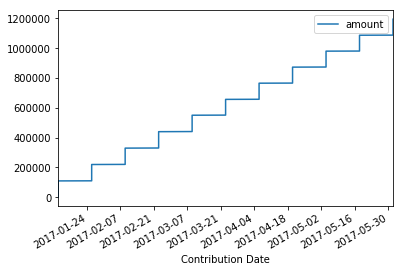

In [46]:
ts_df.xs('8600230').cumsum().plot()

In [47]:
expense[expense.filer_id=='8200581']

,Filer Identification Number,Election Year,Election Cycle,Name,Expense Address 1,Expense Address 2,Expense City,Expense State,Expense Zip Code,Expense Date,Expense Amount,Expense Description,Expense Location 1,Expense Location 2,amount,filer_id,lat,long,address
73,8200581,2017,3,Dayna Flood,2751 Croydon St,,Philadelphia,PA,191371528,2017-05-26,$45.00,Non-fed GOTV phone banks,"2751 Croydon St\nPhiladelphia, PA 191371528\n(...","Philadelphia, PA 191371528\n(39.996078, -75.07...",45.0,8200581,39.996074,-75.076904,2751 Croydon St Philadelphia PA 191371528
806,8200581,2017,3,Vincent Paley Jr.,132 Pierce Street,,Philadelphia,PA,191481910,2017-05-23,$125.00,Primary election day - trash removal at EOM,"132 Pierce Street\nPhiladelphia, PA 191481910\...","Philadelphia, PA 191481910\n(39.925817, -75.14...",125.0,8200581,39.925780,-75.148363,132 Pierce Street Philadelphia PA 191481910
1371,8200581,2017,1,Lazaretto Ballroom,Morton Ave,Capo 801,Folsom,PA,190332994,2017-03-20,$5100.00,In-kind contrib: Jack Whelan for PA Judge,"Morton Ave\nFolsom, PA 190332994\n","Capo 801\nFolsom, PA 190332994\n",5100.0,8200581,NaN,NaN,Morton Ave Capo 801 Folsom PA 190332994
2889,8200581,2017,3,River Wards United,417 Girard Avenue,,Philadelphia,PA,19125,2017-05-09,$26400.00,Contribution for non-fed GOTV Operations,"417 Girard Avenue\nPhiladelphia, PA 19125\n(39...","Philadelphia, PA 19125\n(39.977355, -75.125838)",26400.0,8200581,39.970387,-75.129925,417 Girard Avenue Philadelphia PA 19125
2941,8200581,2017,3,Strassheim Graphic & Design Press Corp,333 N 15th St,,Philadelphia,PA,191021034,2017-05-03,$1738.80,Indep Expend: Butkovitz for Controller signs,"333 N 15th St\nPhiladelphia, PA 191021034\n(39...","Philadelphia, PA 191021034\n(39.953337, -75.16...",1738.8,8200581,39.959349,-75.163827,333 N 15th St Philadelphia PA 191021034
5790,8200581,2017,1,DeAngelo for Assembly,105 Limewood Drive,,Hamilton,NJ,86902212,2017-03-24,$2500.00,Non-fed fundraiser 3/29/17,"105 Limewood Drive\nHamilton, NJ 86902212\n(40...","Hamilton, NJ 86902212\n(40.223999, -74.743202)",2500.0,8200581,40.211306,-74.646835,105 Limewood Drive Hamilton NJ 86902212
6947,8200581,2017,2,Friends of Judge Maria Mclaughlin,1500 JFK Blvd.,PO Box 58381,Philadelphia,PA,191021710,2017-04-26,$15178.00,Donation for lawn signs,"1500 JFK Blvd.\nPhiladelphia, PA 191021710\n","PO Box 58381\nPhiladelphia, PA 191021710\n",15178.0,8200581,NaN,NaN,1500 JFK Blvd. PO Box 58381 Philadelphia PA 19...
6948,8200581,2017,2,Committee to Elect Stella Tsai Judge,1500 JFK Blvd.,PO Box 58381,Philadelphia,PA,191021710,2017-04-28,$5000.00,Non-fed contribution,"1500 JFK Blvd.\nPhiladelphia, PA 191021710\n","PO Box 58381\nPhiladelphia, PA 191021710\n",5000.0,8200581,NaN,NaN,1500 JFK Blvd. PO Box 58381 Philadelphia PA 19...
8843,8200581,2017,3,Tommie St. Hill,2200 Ben Franklin Pkwy,Ste 1106,Phila,PA,191303601,2017-05-11,$27550.00,5/17 Primary GOTV consulting services,"2200 Ben Franklin Pkwy\nPhila, PA 191303601\n","Ste 1106\nPhila, PA 191303601\n",27550.0,8200581,NaN,NaN,2200 Ben Franklin Pkwy Ste 1106 Phila PA 19130...
8847,8200581,2017,3,Jeff Dempsey,,,,,,2017-05-12,$2500.00,Non-fed GOTV consulting services - 5/16/17 Pri...,,,2500.0,8200581,NaN,NaN,


In [48]:
filer[filer.filer_id.isin(['8600230', '8200581', '7900477', '2002281', '7900366'])]

,Filer Identification Number,Election Year,Election Cycle,Amended Report Indicator,Termination Indicator,Filer Type,Filer Name,Office,District,Party,...,Beginning Balance,Monetary,In-Kind,Filer Location 1,Filer Location 2,type,filer_id,lat,long,address
327,2002281,2017,2,N,N,2,"Enterprise Holdings, Inc. Political Action Co...",,,,...,$1619563.63,$14374.34,$0.00,"600 Corporate Park Drive\nSt. Louis, MO 63105\...","St. Louis, MO 63105\n(38.644275, -90.328681)",committee,2002281,38.643211,-90.345564,600 Corporate Park Drive St. Louis MO 63105
350,8200581,2017,2,N,N,2,International Brotherhood of Electrical Worker...,,,OTH,...,$3374823.74,$1188.59,$0.00,"1719 Spring Garden Street\nPhiladelphia, PA 19...","Philadelphia, PA 19130\n(39.967794, -75.173092)",committee,8200581,39.963205,-75.167030,1719 Spring Garden Street Philadelphia PA 19130
931,8200581,2017,1,N,N,2,International Brotherhood of Electrical Worker...,,,OTH,...,$2196750.68,$5876.22,$0.00,"1719 Spring Garden Street\nPhiladelphia, PA 19...","Philadelphia, PA 19130\n(39.967794, -75.173092)",committee,8200581,39.963205,-75.167030,1719 Spring Garden Street Philadelphia PA 19130
1189,8200581,2017,3,N,N,2,International Brotherhood of Electrical Worker...,,,OTH,...,$3507289.16,$1400.92,$0.00,"1719 Spring Garden Street\nPhiladelphia, PA 19...","Philadelphia, PA 19130\n(39.967794, -75.173092)",committee,8200581,39.963205,-75.167030,1719 Spring Garden Street Philadelphia PA 19130
1193,7900477,2017,3,N,N,2,Bipartisan Voluntary Public Affairs Committee ...,,,,...,$276573.45,$8817.13,$0.00,"249 Fifth Avenue, 21st Floor\nPittsburgh, PA 1...","Pittsburgh, PA 15222\n(40.447118, -79.99313)",committee,7900477,40.440844,-80.000676,"249 Fifth Avenue, 21st Floor Pittsburgh PA 15222"
1298,8600230,2017,3,N,N,2,The Boeing Company Political Action Committee,,,,...,$1145840.23,$5919.09,$0.00,"929 Long Bridge Drive\nArlington, VA 22202\n(3...","Arlington, VA 22202\n(38.857857, -77.055713)",committee,8600230,38.864715,-77.050646,929 Long Bridge Drive Arlington VA 22202
1341,2002281,2017,3,N,N,2,"Enterprise Holdings, Inc. Political Action Co...",,,,...,$1657207.82,$25730.98,$0.00,"600 Corporate Park Drive\nSt. Louis, MO 63105\...","St. Louis, MO 63105\n(38.644275, -90.328681)",committee,2002281,38.643211,-90.345564,600 Corporate Park Drive St. Louis MO 63105
1639,7900366,2017,3,N,N,2,PSEA-PACE FOR STATE ELECTIONS,,,,...,$793083.24,$126376.85,$334.42,"400 N THIRD STREET\nHARRISBURG, PA 171051724\n...","HARRISBURG, PA 171051724\n(40.263788, -76.877124)",committee,7900366,40.263322,-76.884517,400 N THIRD STREET HARRISBURG PA 171051724
1935,7900366,2017,2,N,N,2,PSEA-PACE FOR STATE ELECTIONS,,,,...,$794394.30,$91498.38,$339.75,"400 N THIRD STREET\nHARRISBURG, PA 171051724\n...","HARRISBURG, PA 171051724\n(40.263788, -76.877124)",committee,7900366,40.263322,-76.884517,400 N THIRD STREET HARRISBURG PA 171051724
1972,7900366,2017,1,N,N,2,PSEA-PACE FOR STATE ELECTIONS,,,,...,$665003.79,$154876.46,$1243.90,"400 N THIRD STREET\nHARRISBURG, PA 171051724\n...","HARRISBURG, PA 171051724\n(40.263788, -76.877124)",committee,7900366,40.263322,-76.884517,400 N THIRD STREET HARRISBURG PA 171051724


### `contrib` histogram

In [49]:
contrib.amount.describe()

count    1.553750e+05
mean     4.022043e+02
std      5.133624e+04
min     -7.692000e+01
25%      2.000000e+01
50%      5.000000e+01
75%      1.500000e+02
max      2.017053e+07
Name: amount, dtype: float64

In [50]:
contrib.sort_values('amount', ascending=False).head()

,Filer Identification Number,Election Year,Election Cycle,Section,Contributor,Contributor Address 1,Contributor Address 2,Contributor City,Contributor State,Contributor Zip Code,...,Contribution Description,Contributor Location 1,Contributor Location 2,Employer Location 1,Employer Location 2,amount,filer_id,lat,long,address
41002,2005249,2017,3,ID,J.A. and D.F. Martin,7366 Horst Rd.,,Chambersburg,PA,17202,...,0,"7366 Horst Rd.\nChambersburg, PA 17202\n(39.83...","Chambersburg, PA 17202\n(39.922437, -77.663542)",Inc.&quot;\nChambersburg PA\n,1000 Potato Roll Lane\nChambersburg PA\n,20170531.00,2005249,39.835258,-77.695262,7366 Horst Rd. Chambersburg PA 17202
38721,2004252,2017,3,ID,Contributions from FEC Report (see paper filing),PO Box 1717,,Burlington,VT,5402,...,,"PO Box 1717\nBurlington, VT 5402\n","Burlington, VT 5402\n(44.475949, -73.212481)","PO Box 1717\nBurlington, VT 5402\n","Burlington, VT 5402\n(44.475949, -73.212481)",1218981.90,2004252,44.475949,-73.212481,PO Box 1717 Burlington VT 5402
77563,20170130,2017,2,ID,NON-PENNSYLVANIA CONTRIBUTORS,,,,,,...,,,,,,653980.00,20170130,NaN,NaN,
71984,7900117,2017,2,ID,AGGREGATE OUT OF STATE TRANSACTIONS,60 BOULEVARD OF THE ALLIES,,PITTSBURGH,PA,15222,...,,"60 BOULEVARD OF THE ALLIES\nPITTSBURGH, PA 152...","PITTSBURGH, PA 15222\n(40.447118, -79.99313)",,,329402.86,7900117,40.439735,-80.005406,60 BOULEVARD OF THE ALLIES PITTSBURGH PA 15222
127693,20170119,2017,2,ID,JOSEPHINE TEMPLETON,601 PEMBROKE ROAD,,BRYN MAWR,PA,19010,...,,"601 PEMBROKE ROAD\nBRYN MAWR, PA 19010\n(40.02...","BRYN MAWR, PA 19010\n(40.023593, -75.328662)",,,250000.00,20170119,40.024236,-75.305914,601 PEMBROKE ROAD BRYN MAWR PA 19010


In [51]:
contrib[contrib.amount > 5000].shape

(831, 29)

In [52]:
contrib[contrib.amount==contrib.amount.max()]

,Filer Identification Number,Election Year,Election Cycle,Section,Contributor,Contributor Address 1,Contributor Address 2,Contributor City,Contributor State,Contributor Zip Code,...,Contribution Description,Contributor Location 1,Contributor Location 2,Employer Location 1,Employer Location 2,amount,filer_id,lat,long,address
41002,2005249,2017,3,ID,J.A. and D.F. Martin,7366 Horst Rd.,,Chambersburg,PA,17202,...,0,"7366 Horst Rd.\nChambersburg, PA 17202\n(39.83...","Chambersburg, PA 17202\n(39.922437, -77.663542)",Inc.&quot;\nChambersburg PA\n,1000 Potato Roll Lane\nChambersburg PA\n,20170531.0,2005249,39.835258,-77.695262,7366 Horst Rd. Chambersburg PA 17202


In [53]:
filer[filer.filer_id == '2005249']

,Filer Identification Number,Election Year,Election Cycle,Amended Report Indicator,Termination Indicator,Filer Type,Filer Name,Office,District,Party,...,Beginning Balance,Monetary,In-Kind,Filer Location 1,Filer Location 2,type,filer_id,lat,long,address
1572,2005249,2017,1,N,N,2,"EICHELBERGER, JOHN - I LIKE EICH ...",,,REP,...,$58462.80,$0.00,$0.00,"643 HILLSIDE VIEW DR\nDUNCANSVILLE, PA 16635-7...","DUNCANSVILLE, PA 16635-7455\n(40.416439, -78.4...",committee,2005249,40.417011,-78.403791,643 HILLSIDE VIEW DR DUNCANSVILLE ...
1769,2005249,2017,2,N,N,2,"EICHELBERGER, JOHN - I LIKE EICH ...",,,REP,...,$58462.80,$0.00,$0.00,"643 HILLSIDE VIEW DR\nDUNCANSVILLE, PA 16635-7...","DUNCANSVILLE, PA 16635-7455\n(40.416439, -78.4...",committee,2005249,40.417011,-78.403791,643 HILLSIDE VIEW DR DUNCANSVILLE ...
1934,2005249,2017,3,N,N,2,"EICHELBERGER, JOHN - I LIKE EICH ...",,,REP,...,$70185.82,$0.00,$0.00,"643 HILLSIDE VIEW DR\nDUNCANSVILLE, PA 16635-7...","DUNCANSVILLE, PA 16635-7455\n(40.416439, -78.4...",committee,2005249,40.417011,-78.403791,643 HILLSIDE VIEW DR DUNCANSVILLE ...


In [54]:
expense[expense.filer_id == '2005249']

,Filer Identification Number,Election Year,Election Cycle,Name,Expense Address 1,Expense Address 2,Expense City,Expense State,Expense Zip Code,Expense Date,Expense Amount,Expense Description,Expense Location 1,Expense Location 2,amount,filer_id,lat,long,address
265,2005249,2017,2,Altoona Curve Booster Club,P.O. Box 532,,Altoona,PA,16603,2017-03-15,$100.00,Sponsorship,"P.O. Box 532\nAltoona, PA 16603\n","Altoona, PA 16603\n(40.501273, -78.407571)",100.00,2005249,40.501273,-78.407571,P.O. Box 532 Altoona PA 16603
312,2005249,2017,2,Jaffa Shrine Circus,P.O. Box 1984,,Altoona,PA,16603,2017-02-09,$100.00,Ad,"P.O. Box 1984\nAltoona, PA 16603\n","Altoona, PA 16603\n(40.501273, -78.407571)",100.00,2005249,40.501273,-78.407571,P.O. Box 1984 Altoona PA 16603
461,2005249,2017,2,Tyrone Elks Lodge 212,P.O. Box 118,,Tyrone,PA,16686,2017-02-11,$50.00,Sponsorship,"P.O. Box 118\nTyrone, PA 16686\n","Tyrone, PA 16686\n(40.659709, -78.248835)",50.00,2005249,40.659709,-78.248835,P.O. Box 118 Tyrone PA 16686
525,2005249,2017,2,Franklin County Republican Committee,P.O. Box 279,,Chambersburg,PA,17201,2017-02-11,$300.00,Ben Franklin Society Membership,"P.O. Box 279\nChambersburg, PA 17201\n","Chambersburg, PA 17201\n(39.953784, -77.655008)",300.00,2005249,39.953784,-77.655008,P.O. Box 279 Chambersburg PA 17201
921,2005249,2017,2,"Fannett-Metal Fire and Ambulance Co., Inc.",c/o Rita Johns - P.O. Box 51,,Dry Run,PA,17220,2017-04-09,$35.00,Ad,"c/o Rita Johns - P.O. Box 51\nDry Run, PA 17220\n","Dry Run, PA 17220\n(40.185377, -77.735857)",35.00,2005249,40.185377,-77.735857,c/o Rita Johns - P.O. Box 51 Dry Run PA 17220
944,2005249,2017,2,"Complete Insurance Services, Inc.",1213 9th Ave.,,Altoona,PA,16602,2017-03-11,$50.00,Office Services for March,"1213 9th Ave.\nAltoona, PA 16602\n(40.513363, ...","Altoona, PA 16602\n(40.503875, -78.386877)",50.00,2005249,40.513363,-78.399325,1213 9th Ave. Altoona PA 16602
1038,2005249,2017,2,Citizens for Shearer,P.O. Box 948,,Camp Hill,PA,17001,2017-04-15,$100.00,Donation,"P.O. Box 948\nCamp Hill, PA 17001\n","Camp Hill, PA 17001\n(40.24, -76.92)",100.00,2005249,40.240000,-76.920000,P.O. Box 948 Camp Hill PA 17001
1166,2005249,2017,2,Friends of Cristi Waltz,P.O. Box 52,,Duncansville,PA,16635,2017-04-29,$100.00,Donation,"P.O. Box 52\nDuncansville, PA 16635\n","Duncansville, PA 16635\n(40.4157, -78.45712)",100.00,2005249,40.415700,-78.457120,P.O. Box 52 Duncansville PA 16635
1439,2005249,2017,2,Big Brothers/Big Sisters of Blair County,891 23rd St.,,Altoona,PA,16601,2017-02-11,$100.00,Ad,"891 23rd St.\nAltoona, PA 16601\n(40.506421, -...","Altoona, PA 16601\n(40.533435, -78.39462)",100.00,2005249,40.506421,-78.410901,891 23rd St. Altoona PA 16601
1494,2005249,2017,2,Presbyterian Homes Foundation,220 Newry St.,,Hollidaysburg,PA,16648,2017-03-25,$150.00,Sponsor,"220 Newry St.\nHollidaysburg, PA 16648\n(40.42...","Hollidaysburg, PA 16648\n(40.444353, -78.351264)",150.00,2005249,40.425947,-78.398667,220 Newry St. Hollidaysburg PA 16648


# Heatmaps

In [55]:
contrib.groupby('filer_id').count().sort_values('amount', ascending=False).head()

,Filer Identification Number,Election Year,Election Cycle,Section,Contributor,Contributor Address 1,Contributor Address 2,Contributor City,Contributor State,Contributor Zip Code,...,Contribution Amount,Contribution Description,Contributor Location 1,Contributor Location 2,Employer Location 1,Employer Location 2,amount,lat,long,address
filer_id,,,,,,,,,,,,,,,,,,,,,
8600230,28132,28132,28132,28132,28132,28132,28132,28132,28132,28132,...,28132,28132,28132,28132,28132,28132,28132,28132,28132,28132
8200581,17589,17589,17589,17589,17589,17589,17589,17589,17589,17589,...,17589,17589,17589,17589,17589,17589,17589,17589,17589,17589
7900477,9749,9749,9749,9749,9749,9749,9749,9749,9749,9749,...,9749,9749,9749,9749,9749,9749,9749,9749,9749,9749
2002281,7561,7561,7561,7561,7561,7561,7561,7561,7561,7561,...,7561,7561,7561,7561,7561,7561,7561,7544,7544,7561
7900366,6465,6465,6465,6465,6465,6465,6465,6465,6465,6465,...,6465,6465,6465,6465,6465,6465,6465,6454,6454,6465


In [56]:
contrib.groupby(['filer_id', 'Contributor']).count().sort_values('amount', ascending=False).head()

,,Filer Identification Number,Election Year,Election Cycle,Section,Contributor Address 1,Contributor Address 2,Contributor City,Contributor State,Contributor Zip Code,Occupation,...,Contribution Amount,Contribution Description,Contributor Location 1,Contributor Location 2,Employer Location 1,Employer Location 2,amount,lat,long,address
filer_id,Contributor,,,,,,,,,,,,,,,,,,,,,
20150041,Daniel R. Sulman,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
20160352,CEISLER MEDIA & ISSUE ADVOCACY,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
2017C0256,MARK COHEN FOR JUDGE,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39
7900366,JOHN P JONES,34,34,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34
20170131,"BUCHANAN, DIANE ZACK FOR JUDGE",32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32


In [57]:
contrib.groupby('Contributor Zip Code').sum()[['amount']].sort_values('amount', ascending=False).head()

,amount
Contributor Zip Code,
17202,20208147.00
191303915,2870729.03
5402,1218981.90
22202,1198031.91
19103,1095895.23


In [58]:
contrib.groupby('filer_id').mean().sort_values('amount', ascending=False).head()

,Election Year,Election Cycle,amount,lat,long
filer_id,,,,,
2004252,2017.0,3.000000,1.218982e+06,44.475949,-73.212481
2005249,2017.0,1.811321,3.811421e+05,39.950659,-77.466003
20170130,2017.0,2.500000,3.272380e+05,NaN,NaN
20170119,2017.0,2.000000,1.275000e+05,40.169085,-77.129387
20150138,2017.0,2.000000,1.097585e+05,38.909170,-77.042056


# Play with fuzzywuzzy